In [60]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Simulation space dimensions, etc.
nx = 503
ny = 501
xmax = 2000.0 # micrometers
ymax = 2000.0
L_from_source = xmax/2
x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]
nxmid = int(nx/2); print('nxmid =', nxmid); print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

# Define the box inside
Ldesired = 70. # Doesn't always work out to this because the grid is discretized
boxrad = int(Ldesired/dx)
Lx = boxrad*dx; 

ixbox = [ix for ix in range(nxmid-boxrad,nxmid+boxrad)]; #print ixbox
iybox = [iy for iy in range(nymid-boxrad,nymid+boxrad)]; #print iybox
ixbot = min(ixbox); #print ixbot
ixtop = max(ixbox); #print ixtop
iylft = min(iybox); #print iylft
iyrgt = max(iybox); #rint iyrgt

# Compute diffusion coefficient at this temperature
D_SI_300 = 24.0e-6 # m^2/s
D_300 = D_SI_300 * 1e6  # um^2/us
Temp = 260.0
Pressure = .2
#Pressure = 2e-5
acoef = 2.072
D = D_300*(Temp/300)**acoef/(Pressure/1.0); print(D_300, D)

# Here's the part that involved some guesswork ... getting the Neumann coefficient
# gneumann_nu_kin = D/((nx-1)*dx**2); print 'gneumann_kin', gneumann_nu_kin 
# gneumann_nu_kin = D/(nx-1); print 'gneumann_kin', gneumann_nu_kin 
# nu_kin_ml = 0.1633333333
# kfactor = gneumann_nu_kin/nu_kin_ml; print 'kfactor', kfactor
# alphasigma = .36; print 'alpha*sigma', alphasigma
# gneumann = kfactor * nu_kin_ml; print 'gneumann', gneumann


dx 3.9840637450199203
nxmid = 251
x(nxmid) = 1000.0
Edge length of box, L = 135.4581673306773 67.72908366533865
24.0 89.20943386022752


In [70]:

# This is the far-field boundary, in supersaturation units
udirichlet = 0.5
sigma_inf = udirichlet

# I think this is the g-value appropriate for a boundary L/2 away
gneumann_limit = D/(L_from_source/2); print('gneumann limit', gneumann_limit)

# Get the density of gas at this temperature
R = 8.314
Delta_H = 50000
Pstar = 611*np.exp(-Delta_H/R*(1/Temp-1/273.)); print('Pstar', Pstar)
c_sat = Pstar/(R*Temp)*18/1e6; print('density of gas (g/cm^3)', c_sat)
c_solid = 1.0 # also in g/cm^3

# Approximate kinetic velocity
nu_kin_surf_solid = 50*(1.0/1e6); print('nu_kin_surf (solid)', nu_kin_surf_solid)  # microns of solid per microsecond
nu_kin_surf = nu_kin_surf_solid*(c_solid/c_sat); print('nu_kin_surf (gas)', nu_kin_surf)  # microns of gas per microsecond

# This is Libbrect's expression for the diffusion-limited growth velocity (for a sphere)
v_diffusionlimited_solid = D*sigma_inf/(L*(c_solid/c_sat)); print('v_diff (solid)', v_diffusionlimited_solid)
v_diffusionlimited = v_diffusionlimited_solid*(c_solid/c_sat); print('v_diff (gas)', v_diffusionlimited)

# Libbrecht's alpha (at -30)
sigma0 = 0.08
bigA = 0.25
# alpha_surf = bigA*np.exp(.19/.2); print('alpha_surface', alpha_surf)
alpha_surf = bigA*np.exp(.2/.22); print('alpha_surface', alpha_surf)
# alpha_diffusionlimited = c_sat*D/(nu_kin*L*c_solid); print('alpha_diff', alpha_diffusionlimited)
alpha_diffusionlimited = c_sat*D/(nu_kin_surf_solid*L*c_solid); print('alpha_diff', alpha_diffusionlimited)
alpha_eff = alpha_surf*alpha_diffusionlimited/(alpha_surf+alpha_diffusionlimited); print('alpha_eff', alpha_eff)

# I think this is the right value
gneumann = alpha_eff*sigma_inf*nu_kin_surf; print('gneumann', gneumann)

# Other parameters
print('Edge length of box, L =', 2*L, L)

gneumann limit 0.17841886772045504
Pstar 203.08822311176192
density of gas (g/cm^3) 1.6911178623691801e-06
nu_kin_surf (solid) 4.9999999999999996e-05
nu_kin_surf (gas) 29.566242018136005
v_diff (solid) 1.1137288364797366e-06
v_diff (gas) 0.6585755264387384
alpha_surface 0.620516271155753
alpha_diff 0.04454915345918947
alpha_eff 0.04156504542939757
gneumann 0.6144610963301932


In [62]:
# Aesthetics ... fills in the box with an arbitrary constant value
def fillin(un,ixbox,iybox):
    border = cp(un[ixbox[0]-1,iybox[0]])
    for ix in ixbox:        
        for iy in iybox:
            un[ix,iy] = border
    return un

# Initialize u0 and un as ones/zeros matrices 
u0 = np.ones([nx, ny])*udirichlet # old u values
u0 = fillin(u0,ixbox, iybox)
u1 = cp(u0)

In [63]:
# Physical parameters translated into values for computation
dx2 = dx**2
dy2 = dy**2
dt = (dx2+dy2)/D/10; print(dt)
Dxeff = D*dt/dx2
Dyeff = D*dt/dy2
gneumanneff = gneumann*dt/dx; print('gneumann_eff', gneumanneff)


# The differential equation solver
def propagate(u0_orig):
    
    # Diffusion
    u0 = cp(u0_orig)
    un = np.zeros(np.shape(u0))
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
    
    # Neumann inner boundary
    un[ixbot-1,iybox] = u0[ixbot-1,iybox] +(u0[ixbot-2,iybox] - u0[ixbot-1,iybox])*Dxeff -gneumanneff
    un[ixtop+1,iybox] = u0[ixtop+1,iybox] +(u0[ixtop+2,iybox] - u0[ixtop+1,iybox])*Dxeff -gneumanneff
    un[ixbox,iylft-1] = u0[ixbox,iylft-1] +(u0[ixbox,iylft-2] - u0[ixbox,iylft-1])*Dyeff -gneumanneff
    un[ixbox,iyrgt+1] = u0[ixbox,iyrgt+1] +(u0[ixbox,iyrgt+2] - u0[ixbox,iyrgt+1])*Dyeff -gneumanneff
    
    # Also zero-out inside the box (this is just aesthetic)
    un = fillin(un,ixbox, iybox)
    
    return un


0.03572801949883472
gneumann_eff 0.005525157953282879


In [64]:
# Propagate forward a bunch of times
ntimes = 5000
un = propagate(u0)
for i in range(ntimes):
    un = propagate(un)

<IPython.core.display.Javascript object>


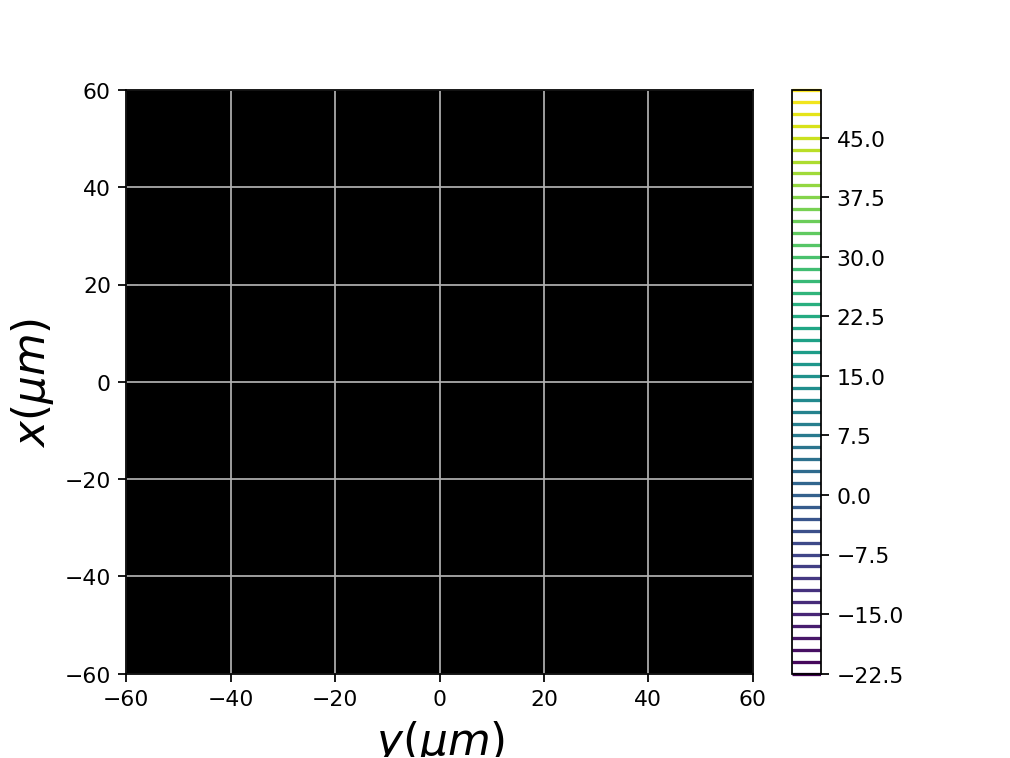

sigma(surface) -21.284479096974675


In [65]:
# Graph as contour plot
fig,ax = plt.subplots()
CS = ax.contour(y,x,un*100,50)
ax.set_xlabel(r'$y (\mu m)$', fontsize=20)
ax.set_ylabel(r'$x (\mu m)$', fontsize=20)
fig.colorbar(CS)
ax.add_patch(patches.Rectangle((y[iybox[0]]-dy,x[ixbox[0]]-dx), L*2+dy, L*2+dx,alpha=None,facecolor="black"))
ax.add_patch(patches.Circle((-dy/2,-dx/2),(L+dx/2)*np.sqrt(2.0),fill=False,linewidth=4))
print('sigma(surface)', np.min(un*100))
dum = 60
ax.set_xlim([-dum,dum])
ax.set_ylim([-dum,dum])
ax.grid('on')

<IPython.core.display.Javascript object>


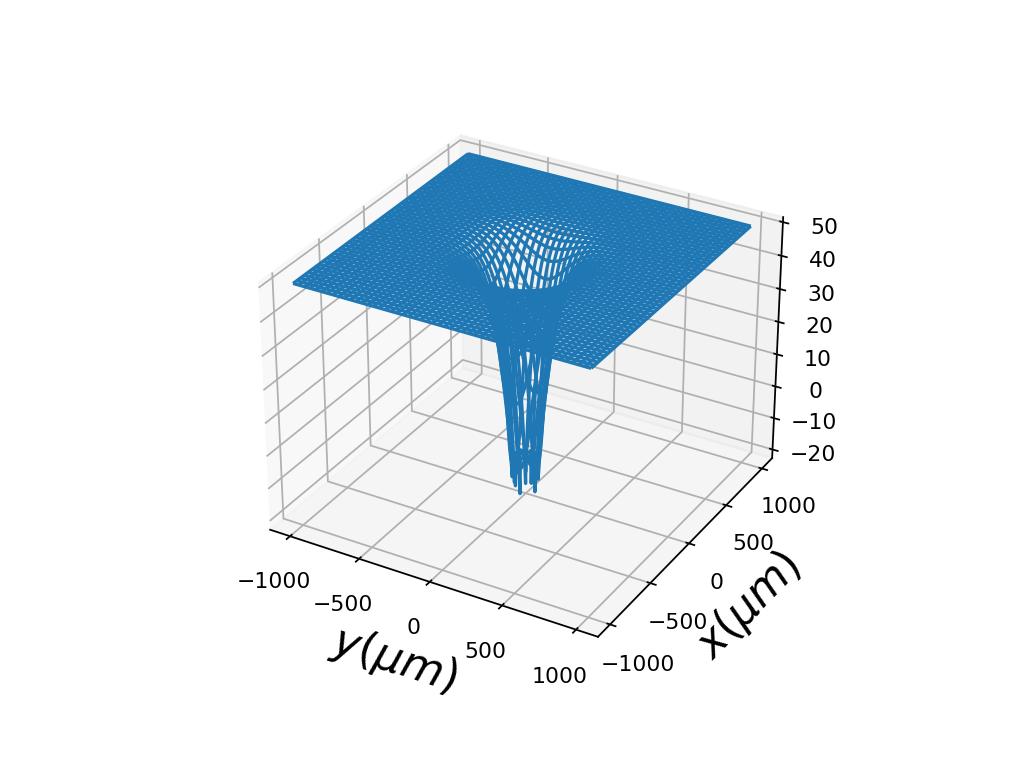

In [66]:
# Graph as mesh plot
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ygrid, xgrid = np.meshgrid(y,x)
ax1.plot_wireframe(ygrid,xgrid,un*100, rstride=10, cstride=10)
#ax1.plot_wireframe(un*100, rstride=10, cstride=10)
ax1.set_xlabel(r'$y (\mu m)$', fontsize=20)
ax1.set_ylabel(r'$x (\mu m)$', fontsize=20)
#ax.add_patch(patches.Rectangle((y[iybox[0]],x[ixbox[0]]), L*2-dy, L*2-dx))
dum = 80

<IPython.core.display.Javascript object>


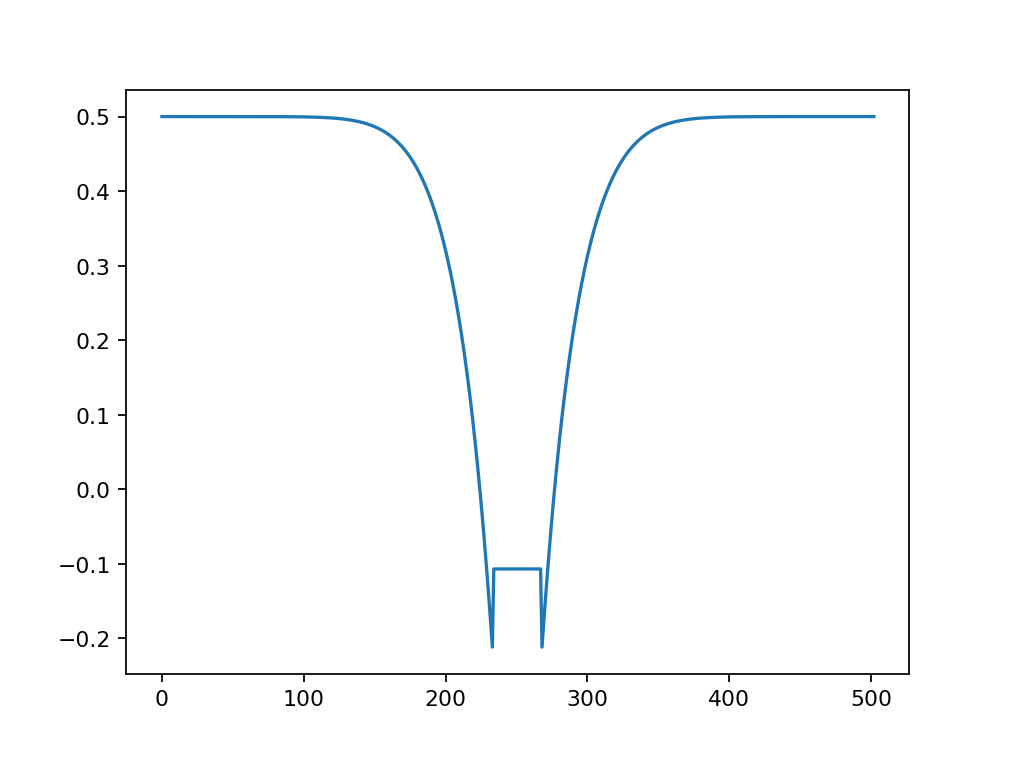

<IPython.core.display.Javascript object>


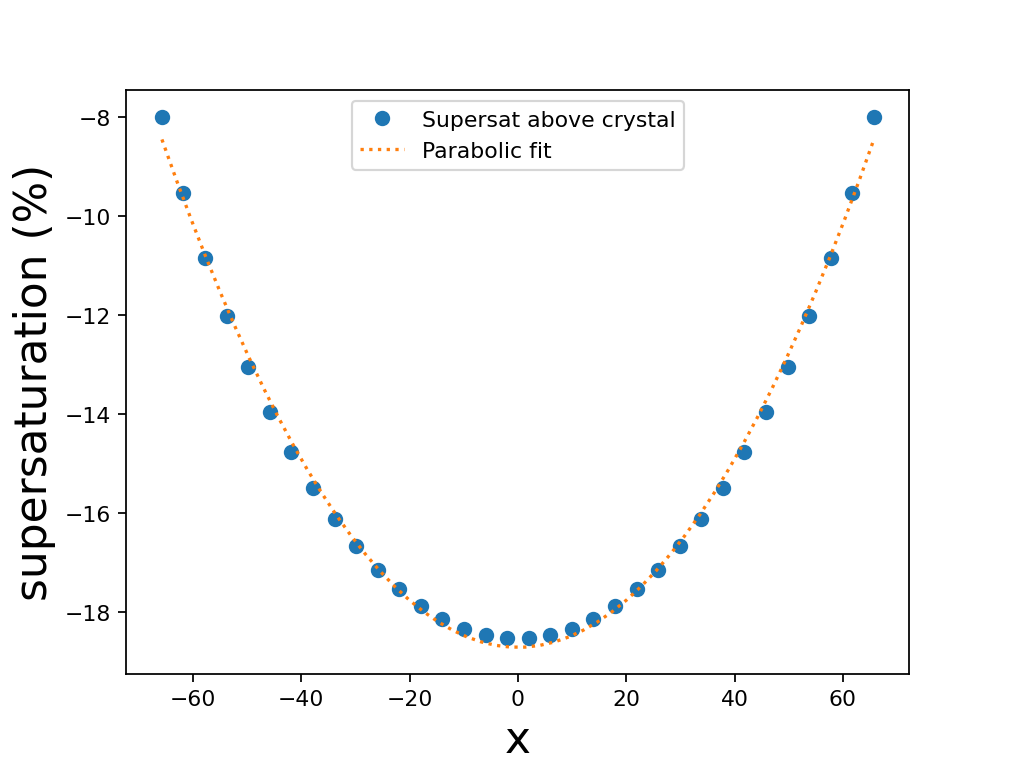

c_r = 10.545713592673192
[ 2.37642259e-05  9.74258311e-19 -1.87197414e-01]


In [67]:
# Show slices through the result

# Just a slice down the middle
plt.figure()
# plt.plot(x[:ixbot],un[:ixbot,nymid])
# plt.plot(x[ixtop+1:],un[ixtop+1:,nymid])
#plt.plot(x,un[:,nymid])
plt.plot(un[:,nymid])

# Now a slice just across one of the box surfaces
plt.figure()
#uscaled = un[ixbox,nymid+boxrad]/max(un[ixbox,nymid+boxrad])
uscaled = un[ixbox,nymid+boxrad+1]
print('c_r =', (max(uscaled)-min(uscaled))*100)
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uscaled*100,'o')
p = np.polyfit(xshifted,uscaled,2); print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory)*100,':')

iextend = 2
bigixbox = [ix for ix in range(nxmid-boxrad-iextend,nxmid+boxrad+iextend)]
biguscaled = un[bigixbox,nymid+boxrad]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.xlabel('x',fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)
# plt.xlim([-L*1.,L*1.1])

plt.legend(['Supersat above crystal','Parabolic fit'],loc='upper center')


<IPython.core.display.Javascript object>


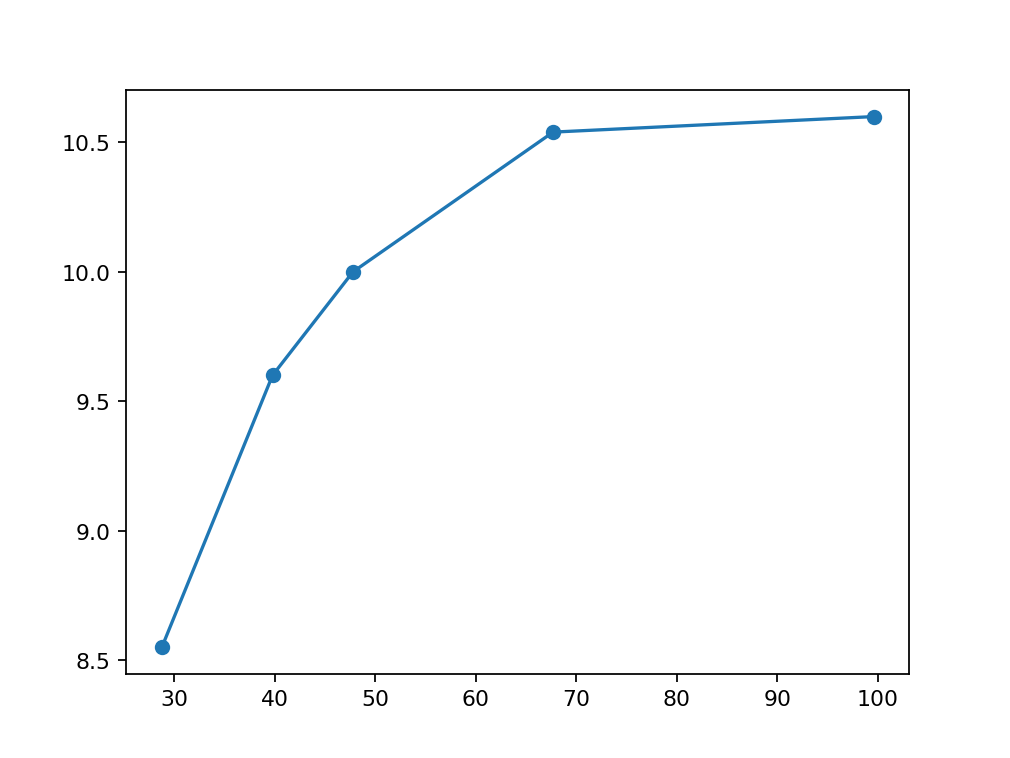

In [71]:
# P=.2 gives c_r = 1.09842173551

L_list = np.array([28.8, 39.8, 47.8, 67.7, 99.6])
c_re_list = np.array([8.55, 9.6, 10.0, 10.54, 10.6])
plt.figure()
plt.plot(L_list,c_re_list, '-o', label=)